In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
! unzip /content/face-expression-recognition-dataset.zip -d /content/face

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras.layers import Rescaling, Dense, Input, Conv2D, BatchNormalization, MaxPool2D, ReLU, GlobalAveragePooling2D, Flatten, Dropout, ELU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [5]:
# get all images full path

data_path = []

data_dir = '/content/face/images'
for root, dirs, files in os.walk(data_dir):
    for name in files:
        data_path.append(os.path.join(root, name))

print(data_path[:10])

#  shuffle the data befor spliting

np.random.shuffle(data_path)
print(data_path[:10])

['/content/face/images/train/neutral/13043.jpg', '/content/face/images/train/neutral/29885.jpg', '/content/face/images/train/neutral/23247.jpg', '/content/face/images/train/neutral/12347.jpg', '/content/face/images/train/neutral/22579.jpg', '/content/face/images/train/neutral/13275.jpg', '/content/face/images/train/neutral/31831.jpg', '/content/face/images/train/neutral/23643.jpg', '/content/face/images/train/neutral/23144.jpg', '/content/face/images/train/neutral/23193.jpg']
['/content/face/images/train/happy/26507.jpg', '/content/face/images/train/angry/28860.jpg', '/content/face/images/train/fear/9316.jpg', '/content/face/images/train/sad/4447.jpg', '/content/face/images/train/happy/6392.jpg', '/content/face/images/train/angry/10038.jpg', '/content/face/images/train/neutral/23491.jpg', '/content/face/images/train/sad/6039.jpg', '/content/face/images/train/fear/15998.jpg', '/content/face/images/train/neutral/12507.jpg']


In [6]:

def create_data(array, train_p, val_p, test_p, path):
    """
    create a train & test & validation directory structure like:

    dir :
    -- train:
            img1
            img2
            ...
    -- validation:
            img1
            img2
            ...
    -- test:
            img1
            img2
            ...
    
    params:
        array : list of images path
        train_p : train persent value
        val_p : validation persent value
        test_p : test persent value
        path : where create the structure (nwe path)

    """

    # calculate the persent of each subset
    tp = len(array) * train_p // 100
    vp = len(array) * val_p // 100
    testp = len(array) * test_p // 100

    # condetional selecting for eath subset 
    train_list = array[:tp]
    val_list = array[tp:tp+vp]
    test_list = array[tp + vp :]

    print('train_list : ', len(train_list), 'images val_list : ', len(val_list), 'images test_list : ', len(test_list), 'images')

    for i in train_list:
        
        dir_name = i.split('/')[-2]
        train_path = path + '/train'

        os.makedirs(os.path.join(train_path, dir_name), exist_ok=True)
        # print(os.path.join(train_path , dir_name))
        shutil.copy(i, os.path.join(train_path, dir_name))
    print('train done')

    for i in val_list:
        
        dir_name = i.split('/')[-2]
        validation_path = path + '/validation'
        
        os.makedirs(os.path.join(validation_path, dir_name), exist_ok=True)
        # print(os.path.join(validation_path , dir_name))
        shutil.copy(i, os.path.join(validation_path, dir_name))
    print('validation done')

    for i in test_list:
        
        dir_name = i.split('/')[-2]
        test_path = path + '/test'
        
        os.makedirs(os.path.join(test_path, dir_name), exist_ok=True)
        # print(os.path.join(test_path , dir_name))
        shutil.copy(i, os.path.join(test_path, dir_name))
    print('test done')


In [7]:
create_data(data_path, 80, 10, 10, 'face_cr')

train_list :  28709 images val_list :  3588 images test_list :  3590 images
train done
validation done
test done


In [4]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_data_gen = ImageDataGenerator(
    rescale=1./255,)

In [8]:
train_data = train_data_gen.flow_from_directory(
    directory='/content/face_cr/train',
    batch_size = 64,
    target_size=(48, 48),
    subset = 'training',
)

validation_data = validation_data_gen.flow_from_directory(
    directory = '/content/face_cr/validation',
    batch_size = 64,
    target_size = (48, 48),

)

test_data = validation_data_gen.flow_from_directory(
    directory = '/content/face_cr/test',
    batch_size = 64,
    target_size = (48, 48),
)

Found 28709 images belonging to 7 classes.
Found 3588 images belonging to 7 classes.
Found 3590 images belonging to 7 classes.


In [9]:
from collections import Counter
counter = Counter(train_data.classes)
print(counter.items())


dict_items([(0, 3986), (1, 433), (2, 4111), (3, 7170), (4, 4927), (5, 4857), (6, 3225)])


In [10]:
classes = {str(y): x for x, y in train_data.class_indices.items()}
classes

{'0': 'angry',
 '1': 'disgust',
 '2': 'fear',
 '3': 'happy',
 '4': 'neutral',
 '5': 'sad',
 '6': 'surprise'}

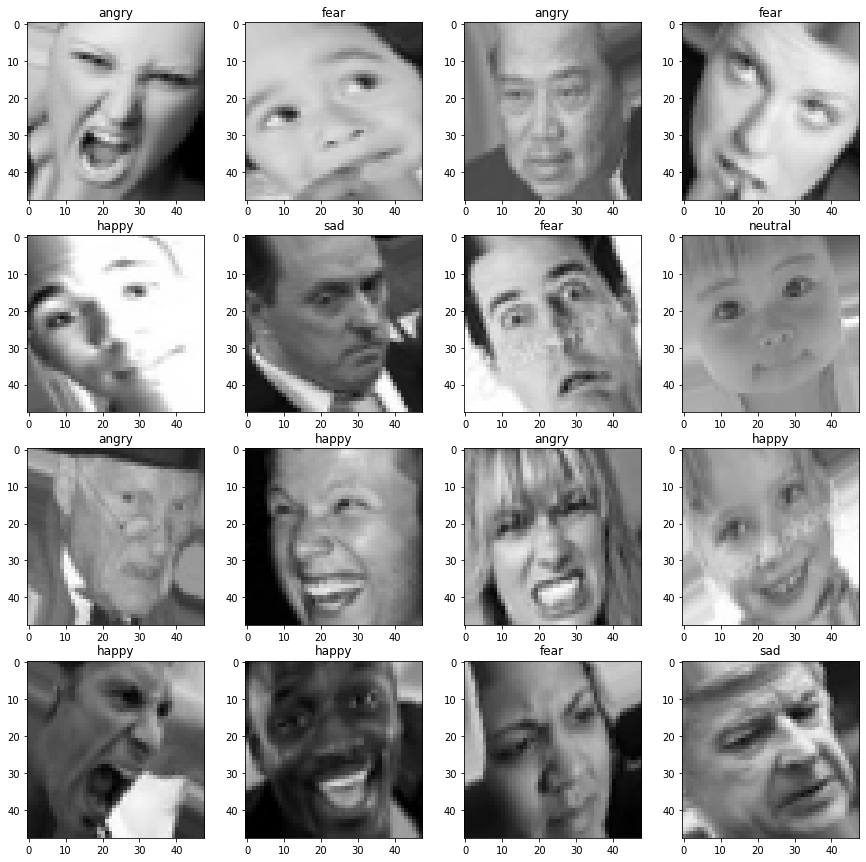

In [11]:
plt.figure(figsize=(15, 15))
for i in range(16):
    plot = plt.subplot(4,4,i+1)
    img, label = train_data.next()
    plot.imshow(img[0])
    label_index = list(label[0]).index(1)
    plot.set_title(classes[str(label_index)])

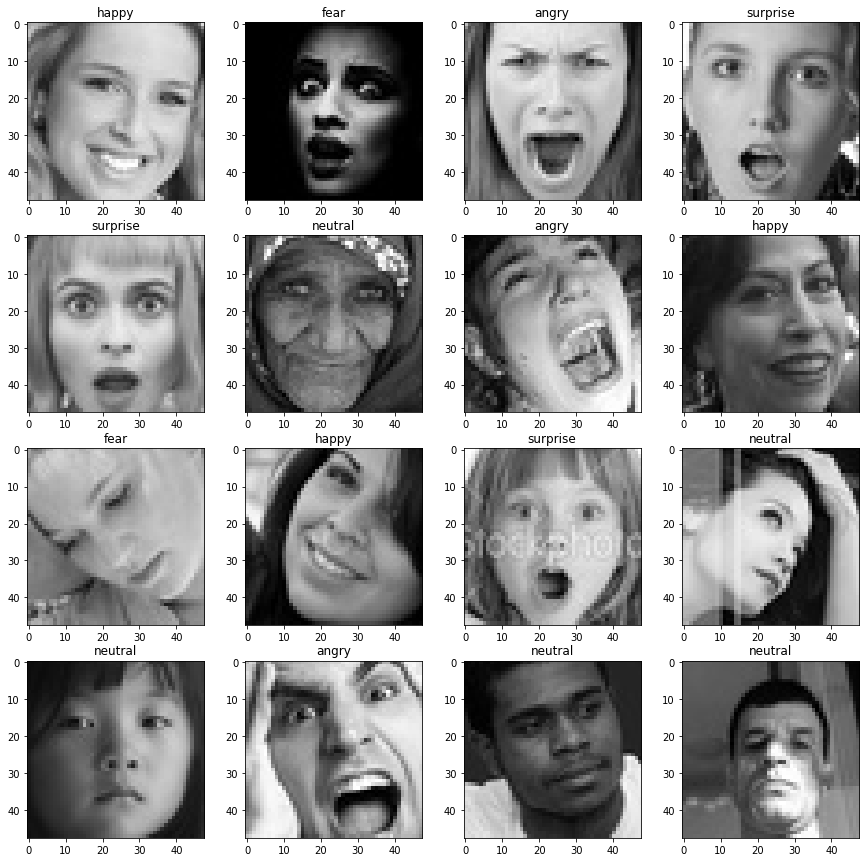

In [12]:
plt.figure(figsize=(15, 15))
for i in range(16):
    plot = plt.subplot(4,4,i+1)
    img, label = validation_data.next()
    plot.imshow(img[0])
    label_index = list(label[0]).index(1)
    plot.set_title(classes[str(label_index)])

In [16]:

# create model from transfer learning

base_model = tf.keras.applications.VGG19(
    include_top = False,
    weights = 'imagenet',
    input_shape = (48,48,3)
)

i = base_model.input

# delet the last max_pool layer from base model after looking the base model summary

x = base_model.output
x = GlobalAveragePooling2D()(x)
fc1 = Dense(units = 128, activation ='relu')(x)
o = Dense(units = 7, activation ='softmax')(fc1)

model = Model(i, o)

model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                            

In [26]:
# callbacks
earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/face_emotion_2.h5', monitor='val_loss', save_best_only=True, verbose=1)


def lr_scheduler(epoch, lr):
    decay_rate = 0.98
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
lr_reduse = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

# complie the model
model.compile(optimizer=Adam(learning_rate = 0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(train_data, validation_data=validation_data, epochs=100, callbacks=[earlystop, lr_reduse ])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/100
449/449 [==============================] - 44s 97ms/step - loss: 0.6253 - accuracy: 0.7715 - val_loss: 0.9255 - val_accuracy: 0.6809 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.799999752431176e-06.
Epoch 2/100
449/449 [==============================] - 41s 91ms/step - loss: 0.5841 - accuracy: 0.7885 - val_loss: 0.9320 - val_accuracy: 0.6839 - lr: 9.8000e-06

Epoch 3: LearningRateScheduler setting learning rate to 9.604000042600092e-06.
Epoch 3/100
449/449 [==============================] - 42s 94ms/step - loss: 0.5646 - accuracy: 0.7957 - val_loss: 0.9378 - val_accuracy: 0.6831 - lr: 9.6040e-06

Epoch 4: LearningRateScheduler setting learning rate to 9.411920291313435e-06.
Epoch 4/100
449/449 [==============================] - 41s 92ms/step - loss: 0.5510 - accuracy: 0.7999 - val_loss: 0.9362 - val_accuracy: 0.6851 - lr: 9.4119e-06

Epoch 5: LearningRateScheduler 

In [ ]:
history = model.history.history

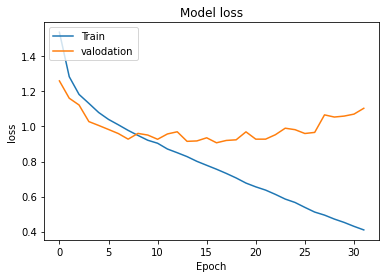

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'valodation'], loc='upper left')
plt.show()

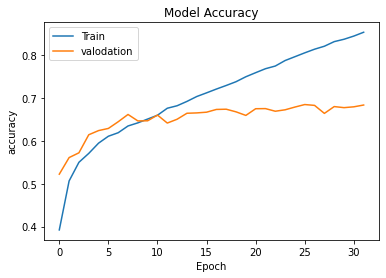

In [21]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'valodation'], loc='upper left')
plt.show()

In [39]:
model.evaluate(test_data)

57/57 [==============================] - 2s 28ms/step - loss: 0.9580 - accuracy: 0.6696


[0.9579654335975647, 0.6696378588676453]

In [40]:
model.evaluate(validation_data)

57/57 [==============================] - 2s 27ms/step - loss: 0.9255 - accuracy: 0.6809


[0.9254591464996338, 0.6808807253837585]

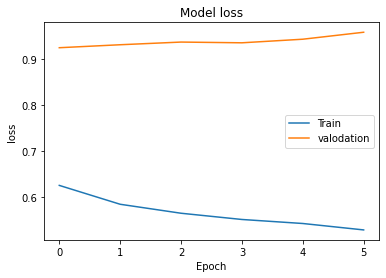

In [37]:
plt.plot(h1['loss'])
plt.plot(h1['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'valodation'], loc='best')
plt.show()

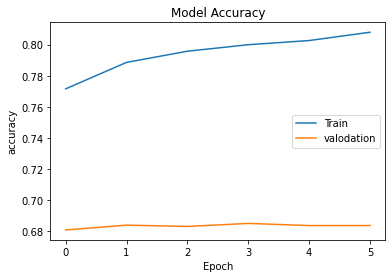

In [41]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'valodation'])
plt.show()

Normalized confusion matrix


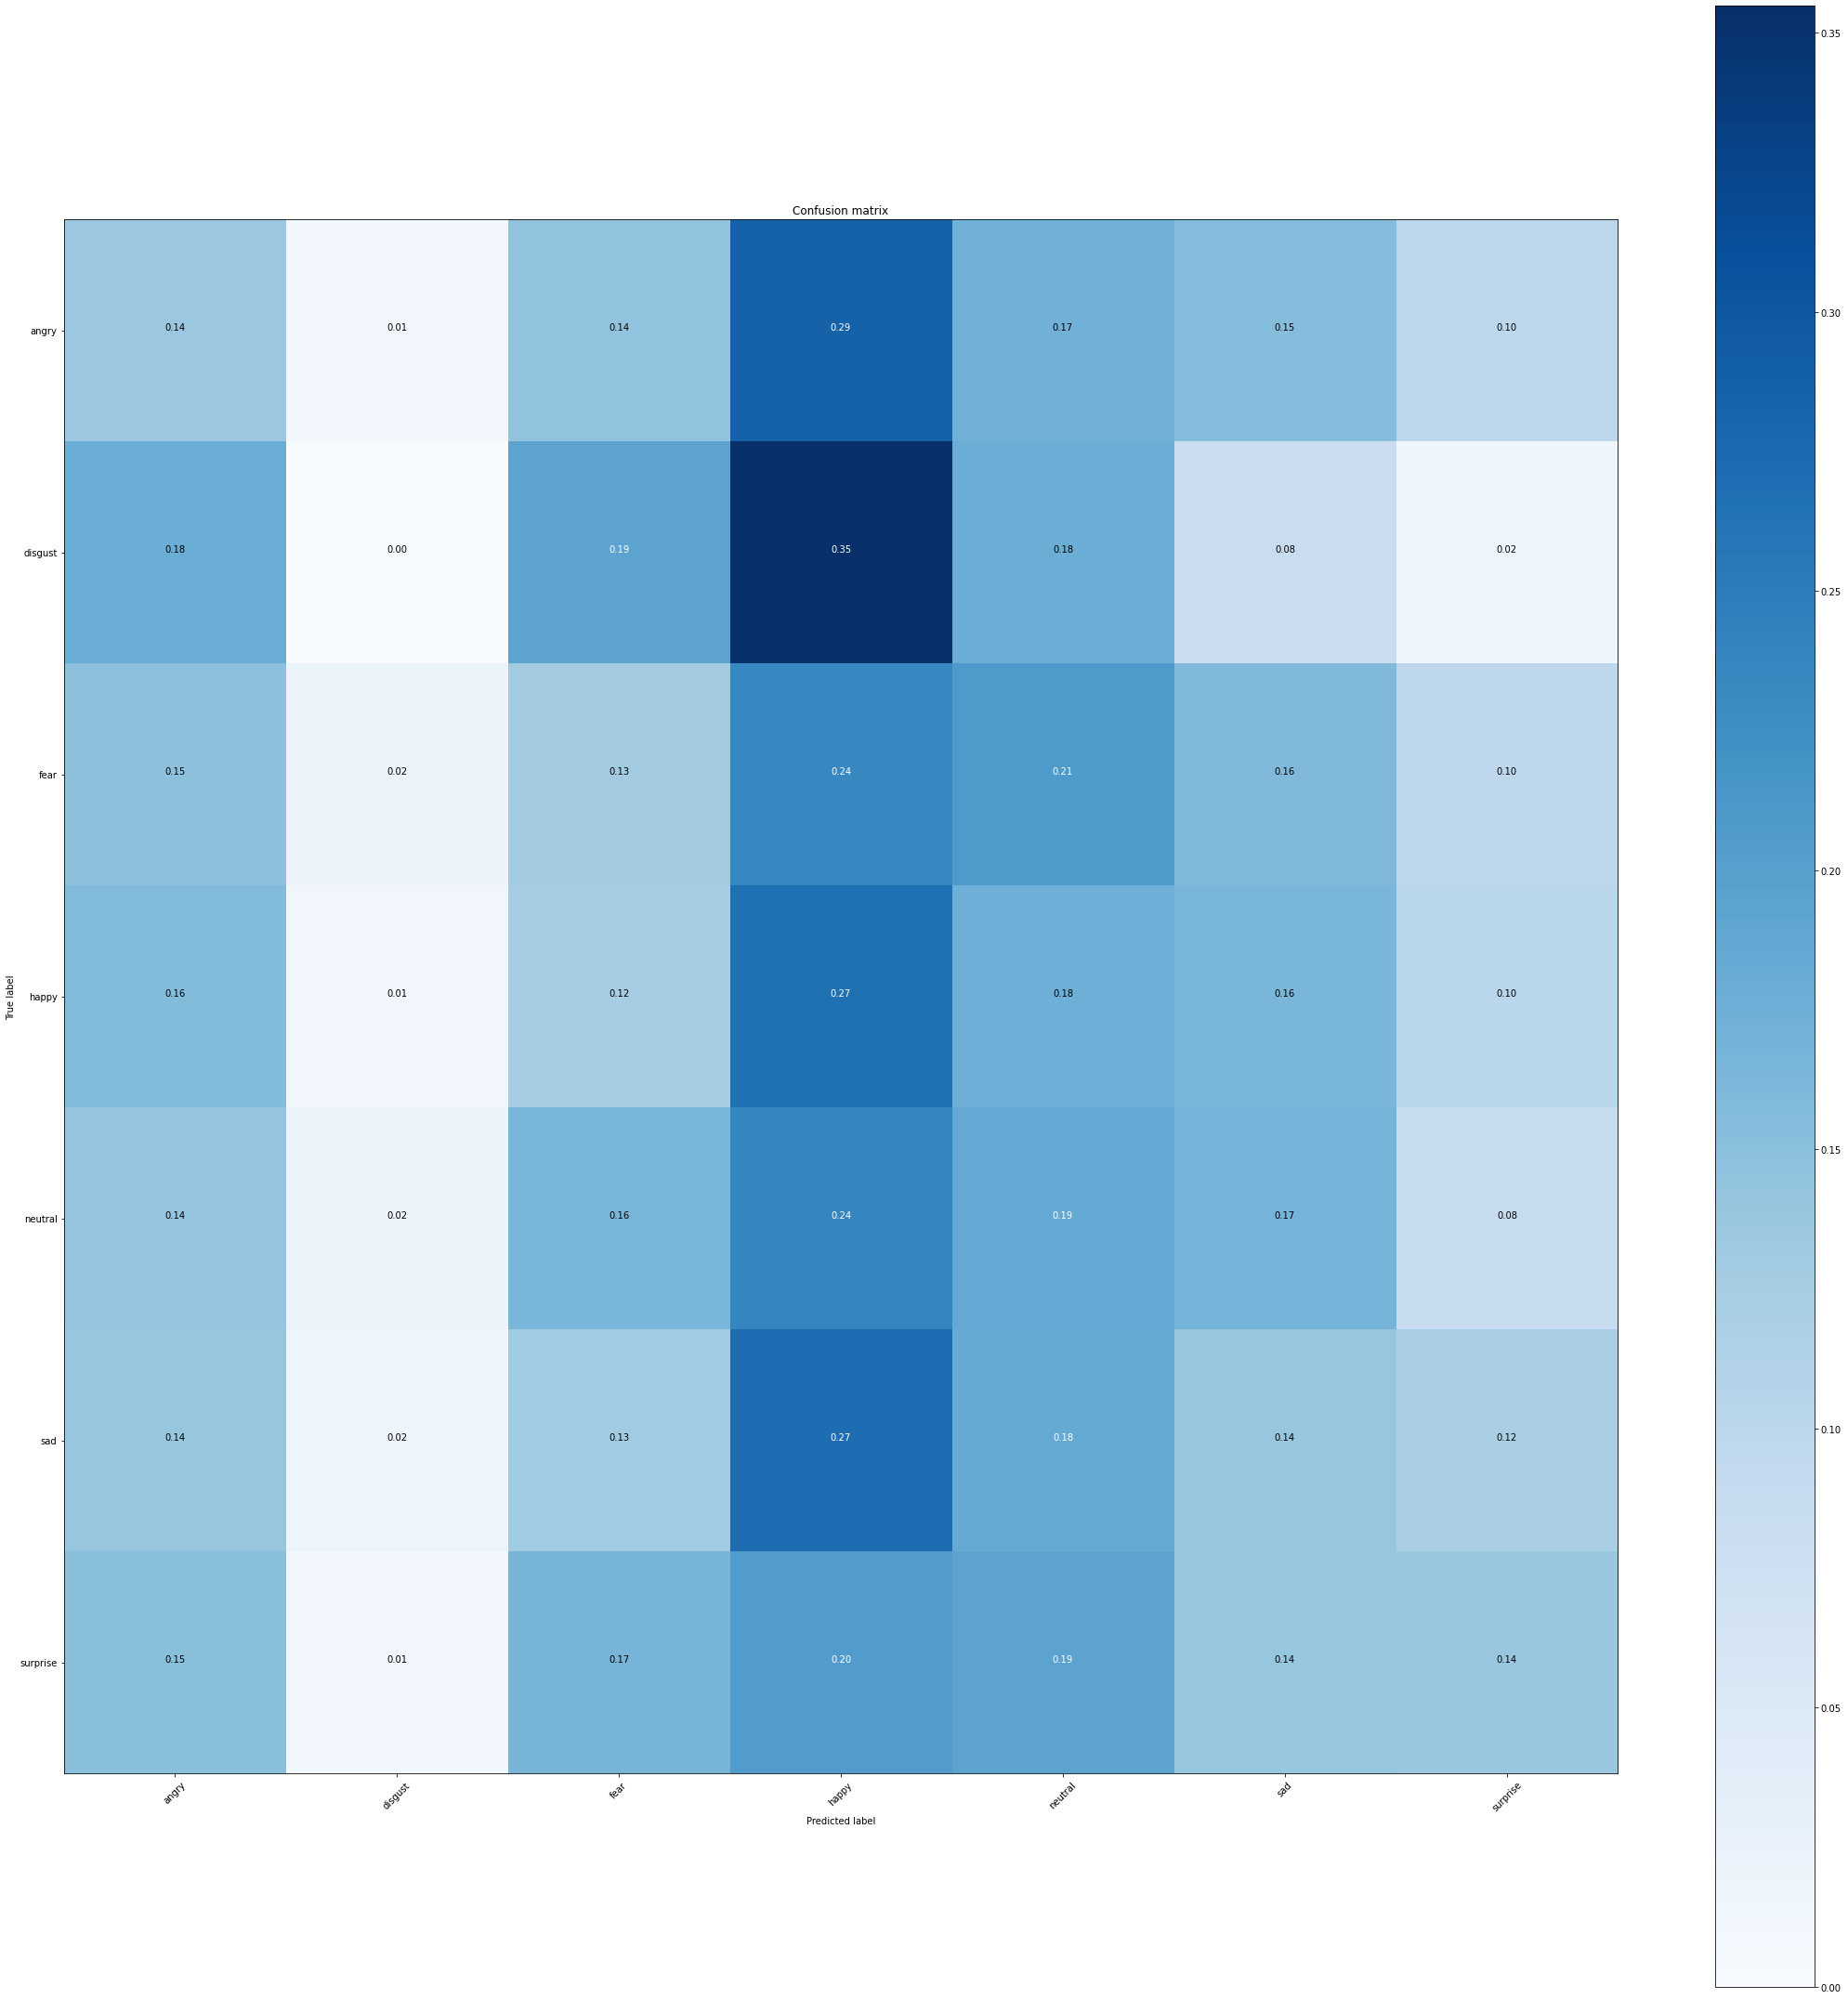

In [46]:
predict = model.predict(test_data)
per = []
for i in predict:
    ii = list(i)
    per.append(ii.index(np.max(i)))
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(30, 30))

    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.savefig('./mc.png')

plot_confusion_matrix(confusion_matrix(test_data.classes, per), classes=test_data.class_indices.keys(), normalize=True)